# FIMPEF: A Framework for Automatic Evaluation of Flood Inundation Mapping Predictions Evaluation Framework
The accuracy of the flood inundation mapping (FIM) is critical for model development and disaster preparedness. The evaluation of flood maps from different sources using geospatial platforms can be tedious and requires repeated processing and analysis for each map. These preprocessing steps includes extracting the correct flood extent, assigning the same projection system to all the maps, categorizing the maps as binary flood maps, removal of permanent water bodies etc. This manual data processing is cumbersome and prone to human error. To address these issues, we developed Flood Inundation Mapping Prediction Evaluation Framework (FIMPEF), a python-based FIM evaluation framework capable of automatically evaluating flood maps from different sources. FIMPEF takes the advantage of comparing multiple target datasets with large benchmark datasets. It includes an option to incorporate permanent waterbodies as non-flood pixels with a user input file or pre-set dataset. In addition to traditional evaluation metrics, it can also compare the number of buildings inundated using a user input file or a pre-set dataset.

# Import Libararies

In [1]:
import geopandas as gpd
import rasterio
import numpy as np
from shapely.ops import unary_union
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio import features
from shapely.geometry import shape
from rasterio.io import MemoryFile
import pandas as pd
from rasterio.features import shapes
from geopandas import GeoDataFrame
from rasterio.crs import CRS  
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask

# Import Permanent Water Bodies
In this work the 'USA Detailed Water Bodies' from ARCGIS hub is used. Here is the link https://hub.arcgis.com/datasets/esri::usa-detailed-water-bodies/about  

In [2]:
pwb= '/...path/PWB/ESRI_PWB/USA_Detailed_Water_Bodies.shp'
gdf = gpd.read_file(pwb)

# Import Benchmark and Candidate Rasters
The benchmark and the candidate rasters must have a valid projection system.

In [3]:
benchmark_path = '..path/benchmark.tif'
candidate_paths = ['...path/candidate1.tif',
                   '...path/candidate2.tif'
                  ]
                  

# Main Code
In this code the analysis which includes raster pre processing - 
1. Determination of the smallest Extent.
2. Conversion into Binary Rasters.
3. Removal of Permanent Water Bodies. 
4. Generation of the contingency rasters with four classes TN, FP,FN, TP.   
5. Calculation of performance scores: CSI, TPR, FNR, Accuracy, Sensitivity, Precision, F1 Score, POD, FPR 

In [4]:
csi_values = []
TN_values=[]
FP_values=[]
FN_values=[]
TP_values=[]
TPR_values=[]
FNR_values=[]
Acc_values=[]
Prec_values=[]
sen_values=[]
F1_values=[]
POD_values=[]
FPR_values=[]
Merged=[]
Unique=[]
with rasterio.open(benchmark_path)as src1:
    benchmark = src1.read(1)
    benchmark_nodata = src1.nodata
    benchmark_transform = src1.transform
    benchmark_meta = src1.meta.copy()
    benchmark_crs=src1.crs
    b_profile=src1.profile
    benchmark[benchmark == benchmark_nodata] = 0
    benchmark = np.where(benchmark > 0, 2, 1)
    %run /..path/Extent.ipynb
    with MemoryFile() as memfile:
        with memfile.open(**benchmark_meta) as mem1:
            mem1.write(benchmark, 1)
            mem1_meta = mem1.meta.copy()
            mem1_crs = mem1.crs
            out_image1, out_transform1 = mask(mem1, [bounding_geom], crop=True, all_touched=True)
            out_image1 = np.where(out_image1 > 1, 2, 0)
            gdf = gdf.to_crs(benchmark_crs)
            shapes1 = [geom for geom in gdf.geometry]
            mask1 = features.geometry_mask(shapes1, transform=out_transform1, invert=True, out_shape=(out_image1.shape[1], out_image1.shape[2]))
            extract_b = np.where(mask1, out_image1, 0)
            extract_b = np.where(extract_b > 0, 1, 0)
            idx_pwb = np.where(extract_b == 1)
            out_image1[idx_pwb] = 0
   
    
def resize_image(source_image, source_transform, source_crs,target_crs, target_shape, target_transform):
    target_image = np.empty(target_shape, dtype=source_image.dtype)
    reproject(
        source=source_image,
        destination=target_image,
        src_transform=source_transform,
        dst_transform=target_transform,
        src_crs= source_crs,
        dst_crs= target_crs,
        resampling=Resampling.nearest
    )
    return target_image

for candidate_path in candidate_paths:
    with rasterio.open(candidate_path) as src2:
        candidate = src2.read(1)
        candidate_nodata = src2.nodata
        candidate_transform = src2.transform
        candidate_meta = src2.meta.copy()
        candidate_crs=src1.crs
        c_profile=src1.profile
        candidate[candidate == candidate_nodata] = 0
        candidate = np.where(candidate > 0, 2, 1)
        with MemoryFile() as memfile:
            with memfile.open(**candidate_meta) as mem2:
                mem2.write(candidate, 1)
                dst_transform, width, height = rasterio.warp.calculate_default_transform(
                mem2.crs, benchmark_crs, mem2.width, mem2.height, *mem2.bounds
                )
                dst_meta = mem2.meta.copy()
                dst_meta.update({
                    'crs': benchmark_crs,
                    'transform': dst_transform,
                    'width': width,
                    'height': height
                })

                with MemoryFile() as memfile_reprojected:
                    with memfile_reprojected.open(**dst_meta) as mem2_reprojected:
                        for i in range(1, mem2.count + 1):
                            reproject(
                            source=rasterio.band(mem2, i),
                            destination=rasterio.band(mem2_reprojected, i),
                            src_transform=mem2.transform,
                            src_crs=mem2.crs,
                            dst_transform=dst_transform,
                            dst_crs=benchmark_crs,
                            resampling=Resampling.nearest
                        )

                        out_image2, out_transform2 = mask(mem2_reprojected, [bounding_geom], crop=True, all_touched=True)
        
                        out_image2 = np.where(out_image2 > 1, 2, 1)
                        mask2 = features.geometry_mask(shapes1, transform=out_transform2, invert=True, out_shape=(out_image2.shape[1] , out_image2.shape[2]))
                        extract_c = np.where(mask2, out_image2, 0)
                        extract_c = np.where(extract_c > 0, 1, 0)
                        idx_pwc = np.where(extract_c == 1)
                        out_image2[idx_pwc] = -1
                        out_image2_resized = resize_image(out_image2, out_transform2, mem2_reprojected.crs, benchmark_crs, out_image1.shape, out_transform1)
                        merged=out_image1+out_image2_resized
                        %run ...path/Evaluation_large_scale.ipynb
                        csi_values.append(CSI)
                        TN_values.append(TN)
                        FP_values.append(FP)
                        FN_values.append(FN)
                        TP_values.append(TP)
                        TPR_values.append(TPR)
                        FNR_values.append(FNR)
                        Acc_values.append(Acc)
                        Prec_values.append(Prec)
                        sen_values.append(sen)
                        F1_values.append(F1_score)
                        POD_values.append(POD)
                        FPR_values.append(FPR)
                        Merged.append(merged)
                        Unique.append(unique_values)

# Contingency Map

/var/folders/sl/ggw6_b1d4jlbhqnnbr1tszg40000gp/T/ipykernel_68759/2231184650.py:55: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches = [Patch(color=custom_colors[i], label=value_labels.get(value, str(value)),


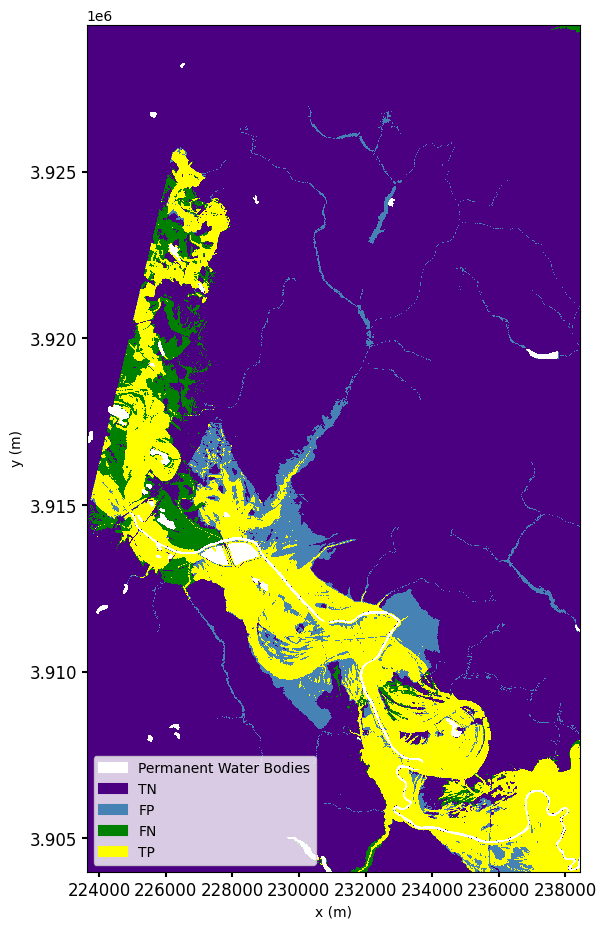

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rasterio
from matplotlib.patches import Patch

if not isinstance(Merged[1], np.ndarray):
    raise TypeError("Merged[0] should be a numpy array.")

if Merged[1].ndim == 3:
    band1 = Merged[1].squeeze()  
elif Merged[1].ndim == 2:
    band1 = Merged[1]
else:
    raise ValueError("Unexpected number of dimensions in Merged[1].")

unique_values = np.unique(band1)


custom_colors = ['white', 'indigo', 'steelblue', 'green', 'yellow', 'red', 'orange', 'purple']
num_unique_values = len(unique_values)


discrete_cmap = ListedColormap(custom_colors[:num_unique_values])

value_labels = {
    1: 'TN',
    2: 'FP',
    3: 'FN',
    4: 'TP',
   -1:'Permanent Water Bodies'
}



value_to_index = {value: index for index, value in enumerate(unique_values)}
band1_mapped = np.vectorize(value_to_index.get)(band1)


if 'out_transform2' not in globals():
    raise NameError("out_transform2 is not defined.")

rows, cols = np.indices(band1.shape)
xs, ys = rasterio.transform.xy(out_transform2, rows, cols)

xs = np.array(xs)
ys = np.array(ys)

plt.figure(figsize=(12, 11))

plt.imshow(band1_mapped, cmap=discrete_cmap, interpolation='none', extent=(
    xs.min(), xs.max(), ys.min(), ys.max()
))

legend_patches = [Patch(color=custom_colors[i], label=value_labels.get(value, str(value)),
                        edgecolor='black', linewidth=1.5)  # Set edge color and width
                  for i, value in enumerate(unique_values)]

plt.legend(handles=legend_patches, loc='lower left')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.tick_params(axis='both', which='both', labelsize='large', width=1.5)  # Adjust label size and width as needed
plt.savefig('..path/contingency.png', dpi=300)
plt.show()


# Storing Data in CSV

In [18]:
d={ 'F1_score':F1_values ,'CSI':csi_values, 'POD':POD_values, 'FNR':FNR_values }
df=pd.DataFrame.from_dict(data=d, orient='index')   
df.columns =['Candidate 1', 'Candidate 2']
df.to_csv('...path/Evaluation.csv', header=True)

# Building Flootprints

The building footprint used is Microsoft release under Open Data Commons Open Database Liocence. Here is the link https://automaticknowledge.co.uk/us-building-footprints/ User can download the building footprints of the desired states from this link.

In [ ]:
polygon_gdf = gpd.read_file('....path/Louisiana_buildings_with_county.gpkg')
polygon_gdf = polygon_gdf.to_crs(data_crs)
%run /...path/Buildings.ipynb
percen_bldg_a=(candidate_results[0]/benchmark_result)         # percentage of building inundated for adjusted SRC
percen_bldg_na =(candidate_results[1]/benchmark_result)       # percentage of buildings inundated for non adjusted SRCs